# **<center>Imports</center>**

In [2]:
#Network
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from keras.layers import concatenate
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.optimizers import Adam, SGD, Adadelta, Lion, Nadam, Ftrl, AdamW
from keras.losses import MeanSquaredError
from keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np

#Images
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.io import imsave
import cv2

#Utilities
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split
from cutecharts.charts import Line
from urllib.request import urlopen
import requests
import warnings
import io
import os

warnings.filterwarnings("ignore")

# **<center>Data Collection</center>**

In [3]:
IMAGE_SIZE = (256, 256)

In [4]:
def prepareInputData(path, h, w):
    X=[]
    y=[]
    for imageDir in os.listdir(path):
        try:
            img = cv2.imread(path + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (w, h)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X.append(img_l)
            y.append(img_ab)
        except:
            pass
    X = np.array(X)
    y = np.array(y)
    
    return X,y

In [39]:
X, y = prepareInputData("../datasets/landscapes/", IMAGE_SIZE[0], IMAGE_SIZE[1])

In [580]:
y[0].shape

(256, 256, 2)

In [6]:
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]
y_train = y[:int(len(y)*0.8)]
y_test = y[:int(len(y)*0.8)]

In [7]:
X_train.shape

(3454, 256, 256)

In [8]:
X_test.shape

(864, 256, 256)

In [206]:
def downloadRawData():
    """
    Obtains data from Kaggle using the API. Only run once (or if you need to
    redownload for some reason).
    """
    api = KaggleApi()
    api.authenticate()

    dataset_name = "vishalsubbiah/pokemon-images-and-types"

    if not os.path.exists("pokemon"):
        os.mkdir("pokemon")

    api.dataset_download_files(dataset_name , path="pokemon1", unzip=True)

# **<center>Making the Model</center>**

In [ ]:
def createModel(networkInput):
    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
 #   my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    #128, 128, 16 with max pooling
    #256, 256, 16 with max pooling


    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

    print(my_model)
    print(networkInput)

    #256, 256, 32 without both, 128, 128, 32 with just first one
    #64, 64, 32 with both, 128, 128, 32 with just second one. 

    
#    my_model = Conv2D(64,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)
    
#    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)
    
#    my_model = Conv2D(256,(3,3),padding='same',strides=1)(my_model)
#    my_model = LeakyReLU()(my_model)
#    my_model = BatchNormalization()(my_model)

    #32, 32, 256
    
#    my_model = UpSampling2D((2, 2))(my_model)

    #64, 64, 256

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #64, 64, 128
    
  #  my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    #128, 128, 64

#    my_model = UpSampling2D((2, 2))(my_model)
    my_model = Conv2D(32,(3,3), padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    print(my_model)
    print(networkInput)
    
    concat_ = concatenate([my_model, networkInput]) 
    
    my_model = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(32,(3,3),padding='same',strides=1)(my_model)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)
    
    my_model = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(my_model)

    return my_model


In [370]:
def createModelTwo(networkInput):
    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(32,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(64,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(256,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(512,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

#    my_model = MaxPooling2D(pool_size=(2,2),padding='same')(my_model)

#    my_model = Conv2D(512,(3,3),padding='same',strides=1)(networkInput)
 #   my_model = LeakyReLU()(my_model)
  #  my_model = BatchNormalization()(my_model)

    my_model = Conv2D(256,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(128,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(64,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(32,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(16,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)

    my_model = Conv2D(64,(3,3),padding='same',strides=1)(networkInput)
    my_model = LeakyReLU()(my_model)
    my_model = BatchNormalization()(my_model)


    my_model = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(my_model)

    return my_model


In [430]:
networkInput = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1],1))
networkOutput = createModelTwo(networkInput)
model_hbl = Model(inputs=networkInput, outputs=networkOutput)

In [431]:
networkInputTwo = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
networkOutputTwo = createModelTwo(networkInputTwo)
model_shc = Model(inputs=networkInputTwo, outputs=networkOutputTwo)

In [432]:
networkInputThree = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
networkOutputThree = createModelTwo(networkInputThree)
model_mse = Model(inputs=networkInputThree, outputs=networkOutputThree)

In [433]:
smoothInput = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
smoothOutput = createModelTwo(smoothInput)
model_smooth = Model(inputs=smoothInput, outputs=smoothOutput)

In [99]:
def custom_loss(y_true, y_pred):
    # Split the predicted and ground truth tensors into a and b channels
    a_true, b_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    a_pred, b_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    
    # Compute the Euclidean distance between a and b channels 4
    color_loss = tf.sqrt(tf.square(a_true - a_pred) + tf.square(b_true - b_pred))
    
    # Compute hue and saturation from a and b channels of predicted image
    hue_true = tf.math.atan2(b_true, a_true) #-pi to pi
    saturation_true = tf.sqrt(tf.square(a_true) + tf.square(b_true)) 
    hue_pred = tf.math.atan2(b_pred, a_pred)
    saturation_pred = tf.sqrt(tf.square(a_pred) + tf.square(b_pred))
    
    # Define the weighting factor for emphasizing saturation over hue
    saturation_weight = 4.0
    
    # Compute the weighted hue-saturation loss
    hue_saturation_loss = tf.square(hue_pred - hue_true) + saturation_weight * tf.square(saturation_pred - saturation_true)
    
    # Combine the color loss and hue-saturation loss
    total_loss = tf.add(0.5*color_loss,hue_saturation_loss)
    
    # Return the mean loss over the batch
    return tf.reduce_mean(tf.sqrt(hue_saturation_loss))


In [440]:
def hue_bin_loss(y_true, y_pred):
    # I made a mistake earlier and was just using y_true and y_pred for hue instead of 
    # calculating it from the a b channels. But, it was actually working pretty well!
    # I think it still worked to achieve my goals because it was combining something
    # pretty similar to huber loss with an extra saturation component. 

    print(f"True shape: {y_true.shape}")
    print(f"Predicted shape: {y_pred.shape}")

    a_true, b_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    a_pred, b_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)

    hue_true = tf.math.atan2(b_true, a_true)
    hue_pred = tf.math.atan2(b_pred, a_pred)

    condition1 = tf.logical_and(tf.less(hue_true, 0), tf.less(hue_pred, 0))
    condition2 = tf.logical_and(tf.greater(hue_true, 0), tf.greater(hue_pred, 0))

    hl = tf.where(condition1 | condition2, 0.0, tf.abs(hue_pred - hue_true))

    saturation_true = tf.sqrt(tf.square(a_true) + tf.square(b_true))
    saturation_pred = tf.sqrt(tf.square(a_pred) + tf.square(b_pred))
    sl = tf.square(saturation_true - saturation_pred)
    

    color_loss = tf.sqrt(tf.square(a_true - a_pred) + tf.square(b_true - b_pred))
    total_loss = tf.add(0.5*color_loss, (0.5*(hl) + sl))

    return tf.reduce_mean(total_loss)  # Use reduce_mean to ensure a scalar loss value

In [393]:
# Define the smoothness loss function with a neural network filter
def smoothness_loss_with_network(y_true, y_pred, initial_filter):
    # Assuming y_true and y_pred are tensors with shape (batch_size, height, width, channels)
    A_true, B_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    A_pred, B_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)

    print(A_true.shape)
    print(A_pred.shape)
    
    # Calculate hue slopes for true and predicted images
    hue_slope_true_A = -B_true / (A_true**2 + B_true**2)
    hue_slope_pred_A = -B_pred / (A_pred**2 + B_pred**2)
    
    hue_slope_true_B = A_true / (A_true**2 + B_true**2)
    hue_slope_pred_B = A_pred / (A_pred**2 + B_pred**2)
    
    # Concatenate the hue slopes for both channels as input channels
    input_channels = tf.concat([hue_slope_true_A, hue_slope_pred_A, hue_slope_true_B, hue_slope_pred_B], axis=-1)
    
    print(f"Input Channels: {input_channels}")

    # Apply convolution operation with the learnable filter
    smoothness_loss = tf.nn.conv2d(input_channels,
                                   initial_filter,
                                   strides=[1, 1, 1, 1],
                                   padding='SAME')
    
    # Remove singleton dimensions added by the convolution operation
    smoothness_loss = tf.squeeze(smoothness_loss, axis=-1)
    # Optionally, you can add further non-linearities or aggregation operations
    print(tf.reduce_mean(tf.square(smoothness_loss)))

    return tf.reduce_mean(tf.square(smoothness_loss))

# Create the trainable variable outside tf.function
initial_filter = tf.Variable(tf.ones([5, 5, 4, 1]), trainable=True)

# Wrap the smoothness_loss_with_network function with tf.function
@tf.function
def smoothness_loss_wrapper(y_true, y_pred):
    print(smoothness_loss_with_network(y_true, y_pred, initial_filter))
    return smoothness_loss_with_network(y_true, y_pred, initial_filter)


In [396]:
yt = y[:5]
yp = y[6:11]

smoothness_loss_with_network(yt, yp, initial_filter)

(5, 256, 256, 1)
(5, 256, 256, 1)
Input Channels: [[[[nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan]
   ...
   [nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan]]

  [[nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan]
   ...
   [nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan]]

  [[nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan]
   ...
   [nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan]]

  ...

  [[nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan]
   ...
   [nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan]]

  [[nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan]
   ...
   [nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan]]

  [[nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan]
   ...
   [nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan]]]


 [[[nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan]
   ...
   [nan nan nan nan]
   [nan nan nan nan]
   [nan nan nan nan

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [232]:
def calculate_smoothness(image):
    batch_size, height, width, channels = image.shape
    print(f"Input shape: {image.shape}")
    
    # Compute gradient in the x-direction
    dx = image[:, :, 1:, :] - image[:, :, :-1, :]
    print(f"dx shape: {dx.shape}")
    
    # Compute gradient in the y-direction
    dy = image[:, 1:, :, :] - image[:, :-1, :, :]
    print(f"dy shape: {dy.shape}")

    # Trim the last row and column of dx and dy to ensure consistent dimensions
    print(f"shape of dx: {dx.shape}")
    dx = dx[:, :-1, :, :]
    print(f"shape after trimming: {dx.shape}")
    print(f"shape of dy: {dy.shape}")
    dy = dy[:, :, :-1, :]
    print(f"shape after trimming: {dy.shape}")
    
    # Calculate smoothness by summing squared gradients
    smoothness = tf.reduce_sum(dx**2 + dy**2, axis=-1)
    print(f"Smoothness shape: {smoothness.shape}")
    
    return smoothness


In [46]:
def color_loss(y_true, y_pred):
    a_true, b_true = tf.split(y_true, num_or_size_splits=2, axis=-1)
    a_pred, b_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)

    loss = tf.sqrt(tf.square(a_true - a_pred) + tf.square(b_true - b_pred))
    return loss

In [441]:
LEARNING_RATE = 0.001
model_hbl.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss=hue_bin_loss)
#model.summary()

In [435]:
model_shc.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=custom_loss
)

In [437]:
model_mse.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="mse"
)

In [405]:
model_smooth.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="mae"
)

In [417]:
NUM_EPOCHS = 500
NUM_STEPS = int(np.floor((len(X)/NUM_EPOCHS))) - 1
VAL_STEPS = int(np.floor(round(len(X_test)//NUM_EPOCHS))) - 1

In [381]:
NUM_STEPS

13

In [438]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,IMAGE_SIZE[0],IMAGE_SIZE[1],1)
        y_input = y_[i].reshape(1,IMAGE_SIZE[0],IMAGE_SIZE[1],2)
        yield (X_input,y_input)

In [439]:
history_shc = model_shc.fit(GenerateInputs(X,y),epochs=NUM_EPOCHS,verbose=1, steps_per_epoch=NUM_STEPS, shuffle=True)#,validation_data=GenerateInputs(X_test, y_test), validation_steps=VAL_STEPS)

Epoch 1/500
1/7 [===>..........................] - ETA: 1s - loss: 2.1448

2024-01-07 08:54:32.714383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 16ms/step - loss: 1.4135
Epoch 2/500
7/7 [==============================] - 0s 15ms/step - loss: 0.8509
Epoch 3/500
7/7 [==============================] - 0s 13ms/step - loss: 1.0032
Epoch 4/500
7/7 [==============================] - 0s 13ms/step - loss: 0.4721
Epoch 5/500
7/7 [==============================] - 0s 13ms/step - loss: 0.6879
Epoch 6/500
7/7 [==============================] - 0s 14ms/step - loss: 0.6375
Epoch 7/500
7/7 [==============================] - 0s 13ms/step - loss: 0.8153
Epoch 8/500
7/7 [==============================] - 0s 13ms/step - loss: 0.5906
Epoch 9/500
7/7 [==============================] - 0s 13ms/step - loss: 0.3164
Epoch 10/500
7/7 [==============================] - 0s 13ms/step - loss: 0.3120
Epoch 11/500
7/7 [==============================] - 0s 13ms/step - loss: 0.2609
Epoch 12/500
7/7 [==============================] - 0s 13ms/step - loss: 0.3317
Epoch 13/500
7/7 [==============================] - 0s 14ms/s

In [442]:
history_hbl = model_hbl.fit(GenerateInputs(X,y),epochs=NUM_EPOCHS,verbose=1, batch_size=32, steps_per_epoch=NUM_STEPS, shuffle=True)#,validation_data=GenerateInputs(X_test, y_test), validation_steps=VAL_STEPS)

Epoch 1/500
True shape: (None, None, None, None)
Predicted shape: (None, None, None, 2)
True shape: (None, None, None, None)
Predicted shape: (None, None, None, 2)


2024-01-07 08:56:01.056229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 17ms/step - loss: 0.4313
Epoch 2/500
7/7 [==============================] - 0s 15ms/step - loss: 0.3276
Epoch 3/500
7/7 [==============================] - 0s 15ms/step - loss: 0.5468
Epoch 4/500
7/7 [==============================] - 0s 16ms/step - loss: 0.3175
Epoch 5/500
7/7 [==============================] - 0s 15ms/step - loss: 0.3532
Epoch 6/500
7/7 [==============================] - 0s 14ms/step - loss: 0.2567
Epoch 7/500
7/7 [==============================] - 0s 14ms/step - loss: 0.3859
Epoch 8/500
7/7 [==============================] - 0s 13ms/step - loss: 0.2959
Epoch 9/500
7/7 [==============================] - 0s 13ms/step - loss: 0.1906
Epoch 10/500
7/7 [==============================] - 0s 13ms/step - loss: 0.3113
Epoch 11/500
7/7 [==============================] - 0s 13ms/step - loss: 0.2333
Epoch 12/500
7/7 [==============================] - 0s 13ms/step - loss: 0.2204
Epoch 13/500
7/7 [==============================] - 0s 13ms/s

In [443]:
history_mse = model_mse.fit(GenerateInputs(X,y),epochs=NUM_EPOCHS,verbose=1, batch_size=32, steps_per_epoch=NUM_STEPS, shuffle=True)#,validation_data=GenerateInputs(X_test, y_test), validation_steps=VAL_STEPS)

Epoch 1/500


7/7 [==============================] - 0s 12ms/step - loss: 0.0311
Epoch 2/500
1/7 [===>..........................] - ETA: 0s - loss: 0.0239

2024-01-07 08:56:49.271155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 10ms/step - loss: 0.0214
Epoch 3/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0820
Epoch 4/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0411
Epoch 5/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0595
Epoch 6/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0280
Epoch 7/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0475
Epoch 8/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0509
Epoch 9/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0267
Epoch 10/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0293
Epoch 11/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0133
Epoch 12/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0109
Epoch 13/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0289
Epoch 14/500
7/7 [==============================] - 0s 10ms/step -

In [406]:
history_smooth = model_smooth.fit(GenerateInputs(X,y),epochs=NUM_EPOCHS,verbose=1, batch_size=32, steps_per_epoch=NUM_STEPS, shuffle=True)#,validation_data=GenerateInputs(X_test, y_test), validation_steps=VAL_STEPS)

Epoch 1/300
 6/13 [============>.................] - ETA: 0s - loss: 0.0712

2024-01-07 08:44:32.414822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 0s 10ms/step - loss: 0.0560
Epoch 2/300
13/13 [==============================] - 0s 10ms/step - loss: 0.0932
Epoch 3/300
13/13 [==============================] - 0s 10ms/step - loss: 0.0860
Epoch 4/300
13/13 [==============================] - 0s 10ms/step - loss: 0.0848
Epoch 5/300
13/13 [==============================] - 0s 10ms/step - loss: 0.0674
Epoch 6/300
13/13 [==============================] - 0s 10ms/step - loss: 0.0453
Epoch 7/300
13/13 [==============================] - 0s 9ms/step - loss: 0.0562
Epoch 8/300
13/13 [==============================] - 0s 9ms/step - loss: 0.0428
Epoch 9/300
13/13 [==============================] - 0s 10ms/step - loss: 0.0506
Epoch 10/300
13/13 [==============================] - 0s 10ms/step - loss: 0.1302
Epoch 11/300
13/13 [==============================] - 0s 9ms/step - loss: 0.0399
Epoch 12/300
13/13 [==============================] - 0s 10ms/step - loss: 0.0777
Epoch 13/300
13/13 [====================

In [420]:
model_hbl.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.15900321>}

In [444]:
data = {
    "hbl loss": list(history_hbl.history["loss"]),
    "shc loss": list(history_shc.history["loss"]),
    "mse loss": list(history_mse.history["loss"]),
#    "mae loss": list(history_smooth.history["loss"])
}

In [445]:
chart = Line("Model Results")
chart.set_options(
    labels=list(range(0, len(history_shc.history["loss"])+1, 20)),
    x_label="Epoch",
    y_label="Loss",
)


chart.add_series("hbl loss", data["hbl loss"])
chart.add_series("shc loss", data["shc loss"])
chart.add_series("mse loss", data["mse loss"])
#chart.add_series("mae loss", data["mae loss"])
chart.render_notebook()

# **<center>Testing the Model</center>**

In [30]:
def ExtractTestInput(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img_=img.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (IMAGE_SIZE[0], IMAGE_SIZE[1])) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,IMAGE_SIZE[0],IMAGE_SIZE[1],1)
    
    return img_l_reshaped

In [490]:
def display_test(imgs):
    num_images = len(imgs)

    # Create a single figure for all images
    plt.figure(figsize=(15, 5 * num_images), linewidth=10, edgecolor="blue")
  #  plt.subplots_adjust(wspace=1.5, hspace=0.5)


    for idx, img in enumerate(imgs):
        img = cv2.imread(img)
        img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))

        # Extract test input
        image_for_test = ExtractTestInput(img)

        # Make predictions using the trained models
        model_hbl_pred = model_hbl.predict(image_for_test)
        model_hbl_pred = model_hbl_pred * 128
        model_hbl_pred = model_hbl_pred.reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 2)

        model_shc_pred = model_shc.predict(image_for_test)
        model_shc_pred = model_shc_pred * 128
        model_shc_pred = model_shc_pred.reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 2)

        model_mse_pred = model3.predict(image_for_test)
        model_mse_pred = model_mse_pred * 128
        model_mse_pred = model_mse_pred.reshape(IMAGE_SIZE[0], IMAGE_SIZE[0], 2)

        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

        comp_hbl = img_lab.copy()
        comp_hbl[:, :, 1:] = model_hbl_pred
        comp_hbl = cv2.cvtColor(comp_hbl, cv2.COLOR_Lab2RGB)

        comp_shc = img_lab.copy()
        comp_shc[:, :, 1:] = model_shc_pred
        comp_shc = cv2.cvtColor(comp_shc, cv2.COLOR_Lab2RGB)

        comp_mse = img_lab.copy()
        comp_mse[:, :, 1:] = model_mse_pred
        comp_mse = cv2.cvtColor(comp_mse, cv2.COLOR_Lab2RGB)

        # Add subplots for each image
        plt.subplot(num_images, 4, idx * 4 + 1)
        img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_original)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_images, 4, idx*4 + 2)
        plt.imshow(comp_hbl)
        plt.title('colorized with hbl')
        plt.axis('off')

        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(comp_shc)
        plt.title("colorized with shc")
        plt.axis('off')

        plt.subplot(num_images, 4, idx * 4 + 4)
        plt.imshow(comp_mse)
        plt.title("colorized with csl")
        plt.axis('off')

    plt.show()
    plt.close()


In [33]:
import random

In [35]:
def get_random_image(folder_path):
    # Get a list of all files in the folder
    all_files = os.listdir(folder_path)

    # Filter only image files (you may need to adjust this based on your image file extensions)
    image_files = [file for file in all_files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # Check if there are any image files in the folder
    if not image_files:
        print("No image files found in the specified folder.")
        return None

    # Select a random image file
    random_image = random.choice(image_files)

    # Construct the full path to the selected image
    image_path = os.path.join(folder_path, random_image)

    return image_path

# Example usage:
folder_path = "../datasets/pokemon/POKEMON/"
random_image_path = get_random_image(folder_path)

if random_image_path:
    print("Random Image Path:", random_image_path)
    # Now you can use this path to load and process the image in your colorization model
else:
    print("Unable to retrieve a random image.")


Random Image Path: ../datasets/pokemon/POKEMON/0602.png


In [145]:
z = "../datasets/pokemon/POKEMON/0001.png"

img = cv2.imread(z)
img.resize(256, 256, 3)
lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
ab = lab[:, :, 1:]

y_hat = model_hbl.predict(ExtractTestInput(img))
y_hat.resize(256, 256, 2)

y_hat = tf.convert_to_tensor(y_hat, dtype=tf.float32)
ab = tf.convert_to_tensor(ab, dtype=tf.float32)

hue_bin_loss(ab, y_hat)

1/1 [==============================] - 0s 10ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=32746.059>

1/1 [==============================] - 0s 10ms/step


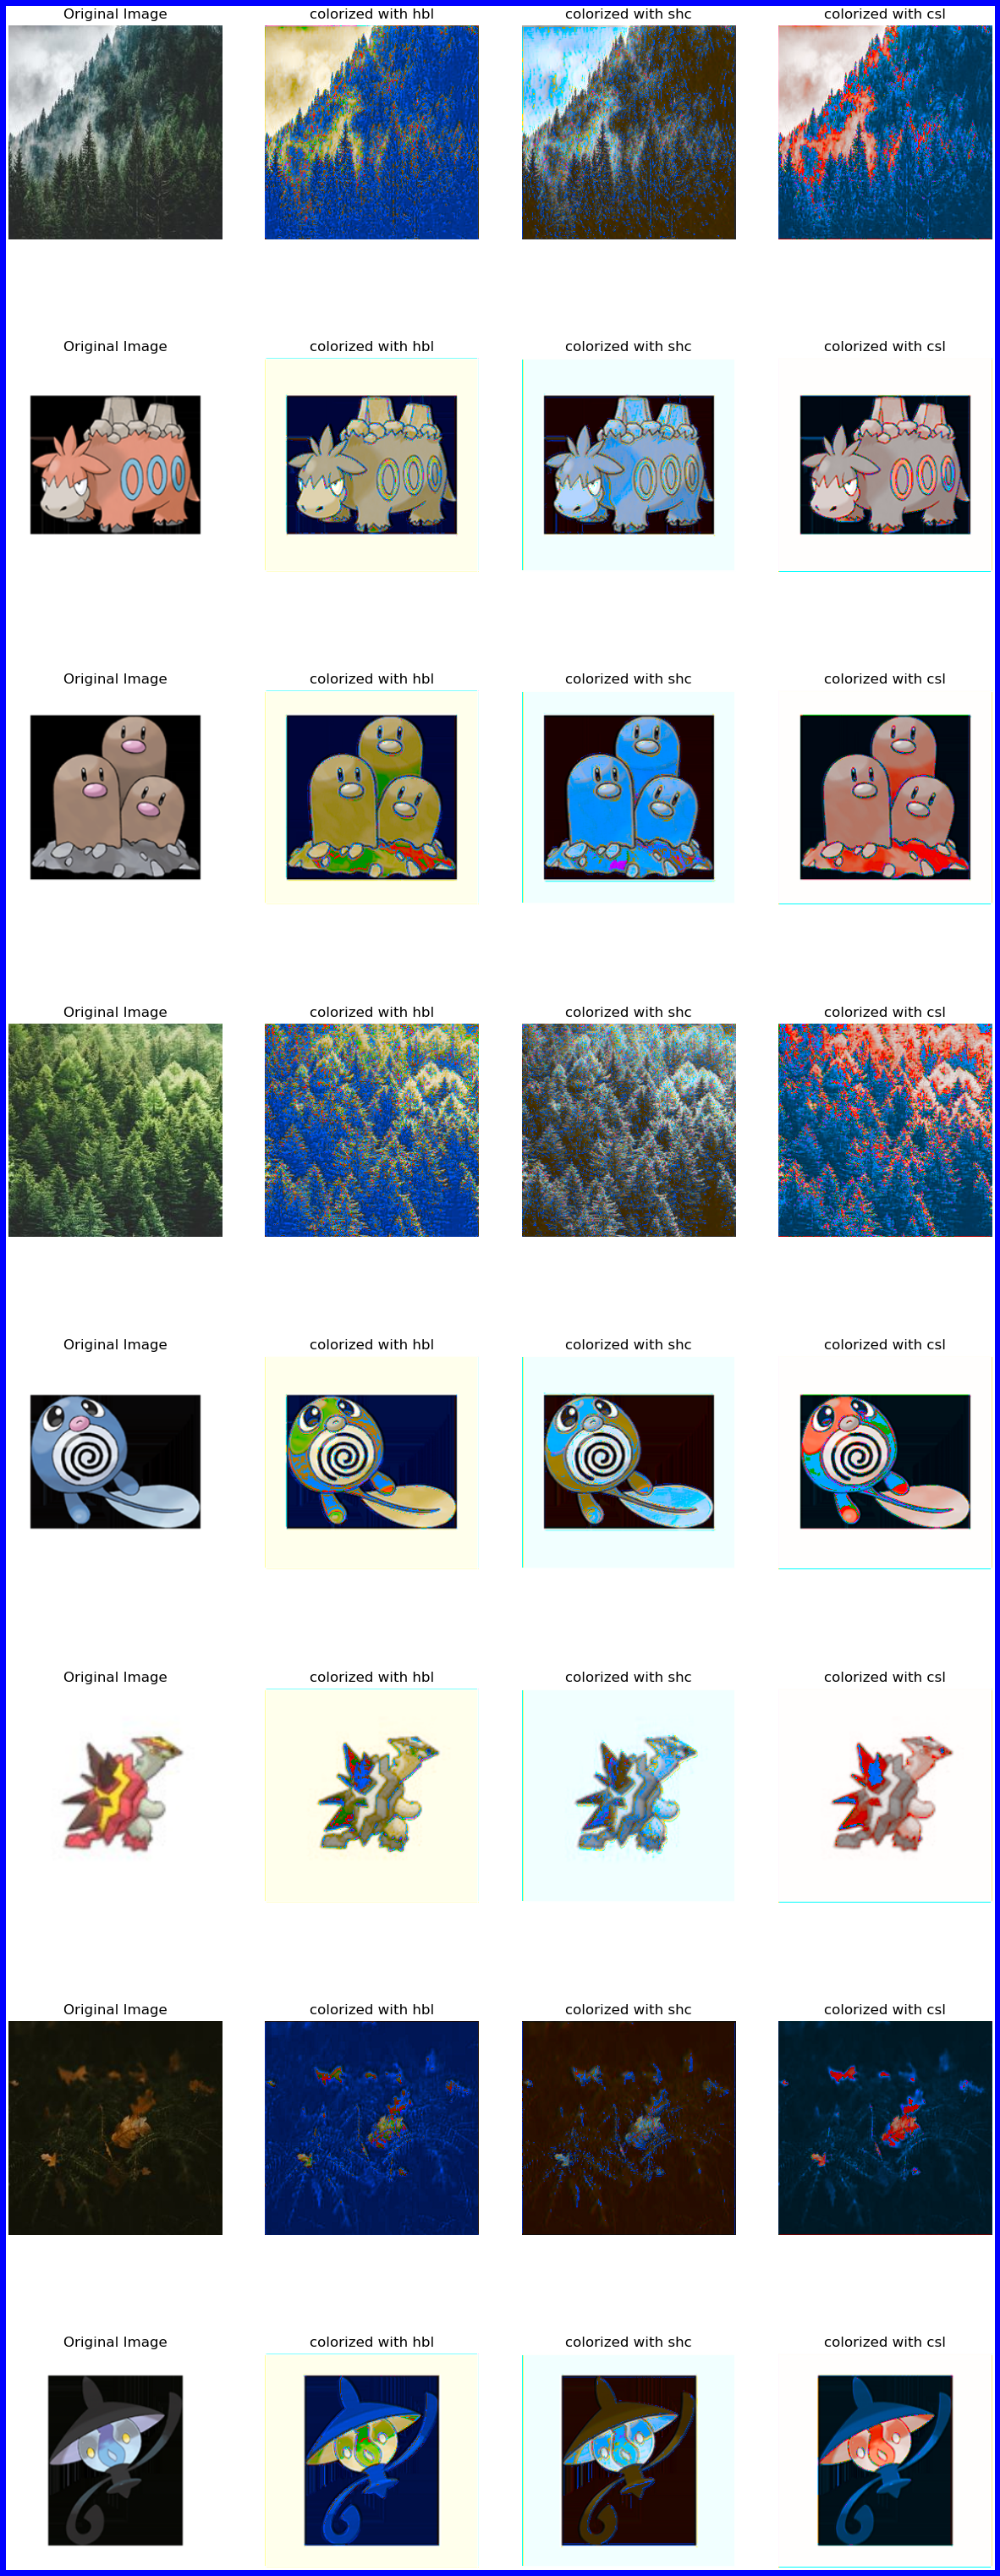

In [492]:

images = []
available_datasets = ["../datasets/pokemon/POKEMON/", "../datasets/pokemon1/images/images/", "../datasets/unsplash/train/train_data/", "../datasets/unsplash/test/test_data/"]
for i in range(8):
    x = str(np.random.choice(available_datasets))
    img = get_random_image(x)
    images.append(img)

display_test(images)

# **<center>Model Saving</center>**

In [464]:
from keras.saving import load_model

In [ ]:
model.save(filepath="256_layers_500_epochs_hbl2.h5")

In [465]:
model3 = load_model("../saved_models/256_layers_500_epochs_hbl.h5", custom_objects={"hue_bin_loss": hue_bin_loss})

1/1 [==============================] - 0s 33ms/step
(1, 256, 256, 1)
(1, 256, 256, 2)


2024-01-07 09:05:05.836939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


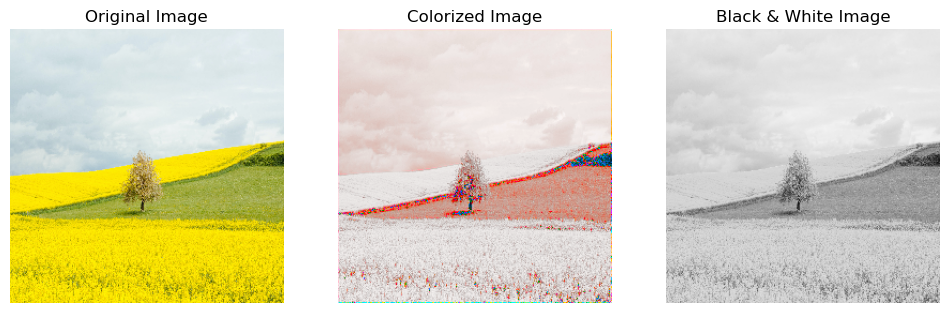

In [466]:
# Load a sample test image
TestImagePath = "../trial.jpg"
img = cv2.imread(TestImagePath)
img = cv2.resize(img, (256, 256))

# Extract test input
image_for_test = ExtractTestInput(img)

# Make a prediction using the trained model
Prediction = model3.predict(image_for_test)
Prediction = Prediction * 128
Prediction = Prediction.reshape(256, 256, 2)
#loss = image_for_test[:,:,1:]-Prediction
print(image_for_test.shape)

# Create Lab image with L channel from original image and predicted a,b channels
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
img_lab_colorized = img_lab.copy()
img_lab_colorized[:, :, 1:] = Prediction

newImg = np.array(image_for_test + Prediction)
#newImg = newImg.reshape(256,256,3)
print(newImg.shape)

# Convert Lab image to RGB
img_colorized = cv2.cvtColor(img_lab_colorized, cv2.COLOR_Lab2RGB)

# Display the images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
img_original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_original)
plt.title("Original Image")
plt.axis('off')

# Colorized Image
plt.subplot(1, 3, 2)
plt.imshow(img_colorized)
plt.title("Colorized Image")
plt.axis('off')

# Ground Truth Image
plt.subplot(1, 3, 3)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
plt.imshow(img_gray)
plt.title("Black & White Image")
plt.axis('off')

plt.show()
plt.close()